In [31]:
import shapefile
import pandas as pd
from shapely import geometry
from pyproj import Proj, transform
import matplotlib.pyplot as plt
import pickle

# convert from Mass xy to latlng
def xy_to_latlng(
    in_coord, # array-like input coords in xy
    inProj = Proj(init = 'epsg:26986'), # Mass x y coord system
    outProj = Proj(init = 'epsg:4326') # lat lng coord system 
    ):
    # note that transform returns in x y
    # which is lng lat
    lng, lat = transform(inProj, outProj, in_coord[0], in_coord[1])
    return (lat, lng)

coast = shapefile.Reader('/Users/Ben/Dropbox/Insight/coast/coast25k/COAST25K_ARC.dbf')
hydro = shapefile.Reader('/Users/Ben/Dropbox/Insight/coast/majorhydro/MAJPOND_POLY.dbf')

In [15]:
# define bounding box
bounds = [[42.24, -71.20], [42.419, -70.94]]
bbox = geometry.box(
    minx = bounds[0][0],
    miny = bounds[0][1],
    maxx = bounds[1][0],
    maxy = bounds[1][1]
)

In [16]:
coast.shapeRecords()[1000].shape.shapeType

3

In [17]:
coast_boxed = list()
for index, line in zip(
    range(len(coast)),
    coast.iterShapes()):
    # points to lat lng
    line_latlng = [xy_to_latlng(point) for point in line.points]
    # make geometry object
    line_obj = geometry.LineString(line_latlng)
    # intersect with bounding box
    line_int = line_obj.intersection(bbox)
#     print(index)
    # if non zero, add to list
    if line_int.length > 0:
        # if it's multiline, append each line separately
        if isinstance(line_int, geometry.multilinestring.MultiLineString):
            for line in line_int.geoms:
                # look up which list to store it in,
                # given the road class
                coast_boxed.append(list(line.coords))
        else:
            # look up which list to store it in,
            # given the road class
            coast_boxed.append(list(line_int.coords))

In [18]:
len(coast_boxed)

29

In [19]:
hydro_boxed = list()
for index, line in zip(
    range(len(hydro)),
    hydro.iterShapes()):
    # points to lat lng
    line_latlng = [xy_to_latlng(point) for point in line.points]
    # make geometry object
    line_obj = geometry.LineString(line_latlng)
    # intersect with bounding box
    line_int = line_obj.intersection(bbox)
#     print(index)
    # if non zero, add to list
    if line_int.length > 0:
        # if it's multiline, append each line separately
        if isinstance(line_int, geometry.multilinestring.MultiLineString):
            for line in line_int.geoms:
                # look up which list to store it in,
                # given the road class
                hydro_boxed.append(list(line.coords))
        else:
            # look up which list to store it in,
            # given the road class
            hydro_boxed.append(list(line_int.coords))

In [20]:
len(hydro_boxed)

13

Text(0, 0.5, 'Latitude')

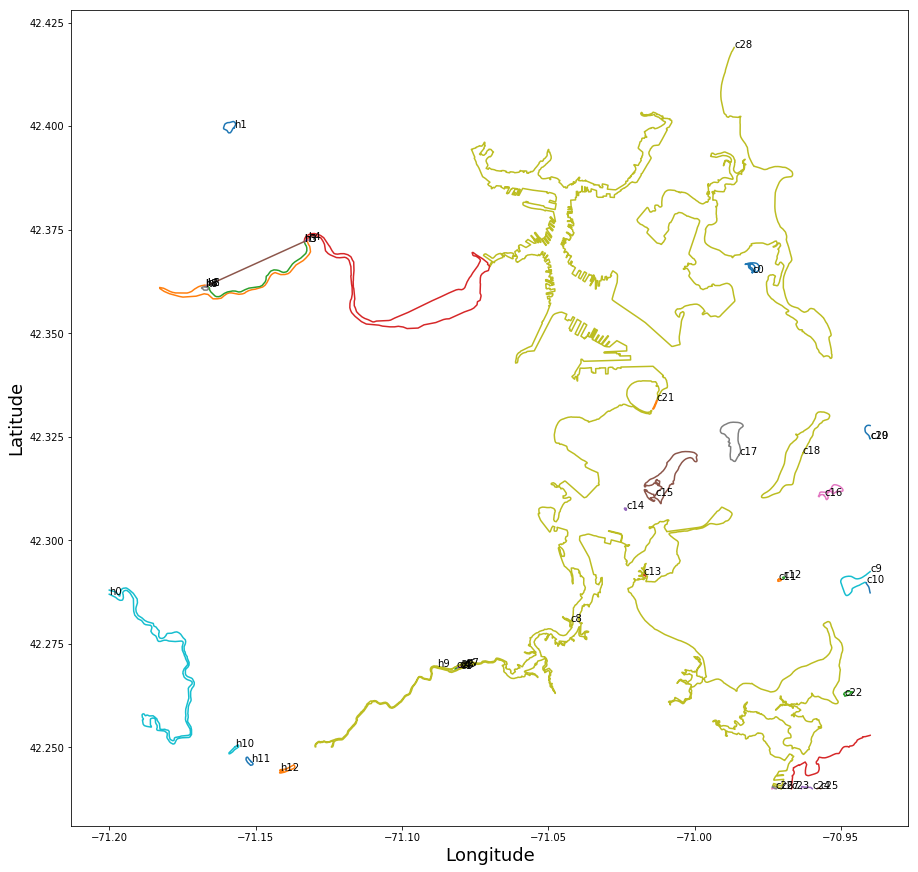

In [21]:
plt.figure(figsize = (15, 15))
for index, line in zip(range(len(coast_boxed)), coast_boxed):
    plt.plot([point[1] for point in line], [point[0] for point in line])
    plt.text(line[-1][1], line[-1][0], s = 'c' + str(index))
for index, line in zip(range(len(hydro_boxed)), hydro_boxed):
    plt.plot([point[1] for point in line], [point[0] for point in line])
    plt.text(line[-1][1], line[-1][0], s = 'h' + str(index))
plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

Text(0, 0.5, 'Latitude')

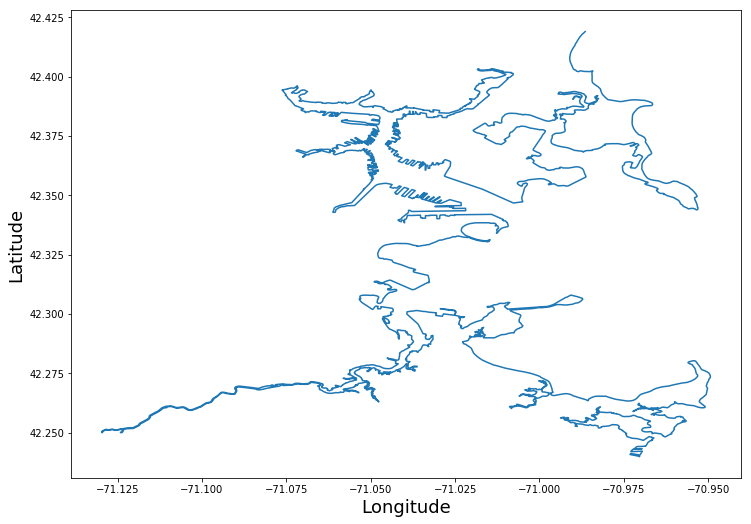

In [22]:
plt.figure(figsize = (12., 8.6))
index = 28
plt.plot([point[1] for point in coast_boxed[index]], [point[0] for point in coast_boxed[index]])
plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

Text(0, 0.5, 'Latitude')

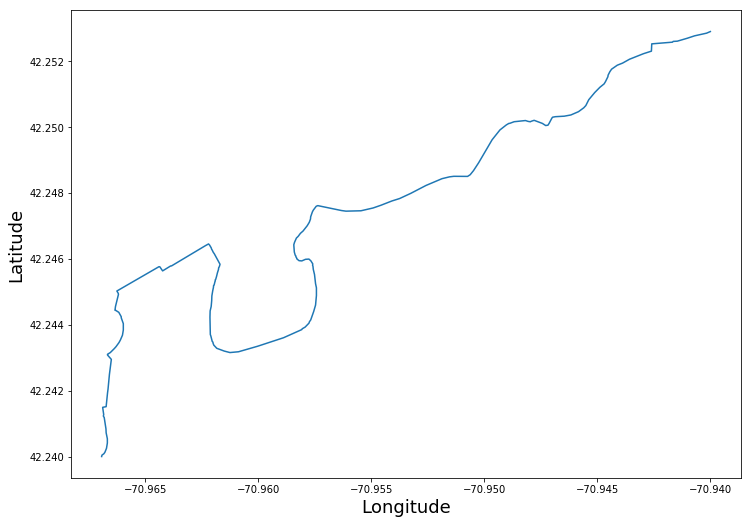

In [26]:
plt.figure(figsize = (12., 8.6))
index = 23
plt.plot([point[1] for point in coast_boxed[index]], [point[0] for point in coast_boxed[index]])
plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

Text(0, 0.5, 'Latitude')

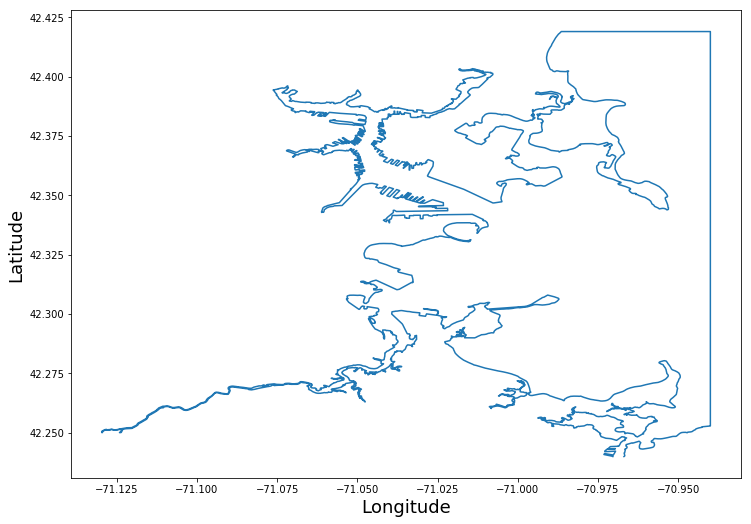

In [40]:
coast_comb = coast_boxed[28] + [(42.419, -70.94)] + coast_boxed[23]

plt.figure(figsize = (12, 8.6))
plt.plot([point[1] for point in coast_comb], [point[0] for point in coast_comb])
plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

In [41]:
coast_boxed[28][0]

(42.24, -70.97036745010118)

In [46]:
(coast_boxed[28][0][0], coast_boxed[28][0][1] + .1)

(42.24, -70.87036745010118)

In [98]:
coast_boxed[23][-1]

(42.24, -70.96692220927852)

In [45]:
(coast_boxed[2][-1][0] + .1, coast_boxed[28][-1][1])

(42.519, -70.9864544593425)

Text(0, 0.5, 'Latitude')

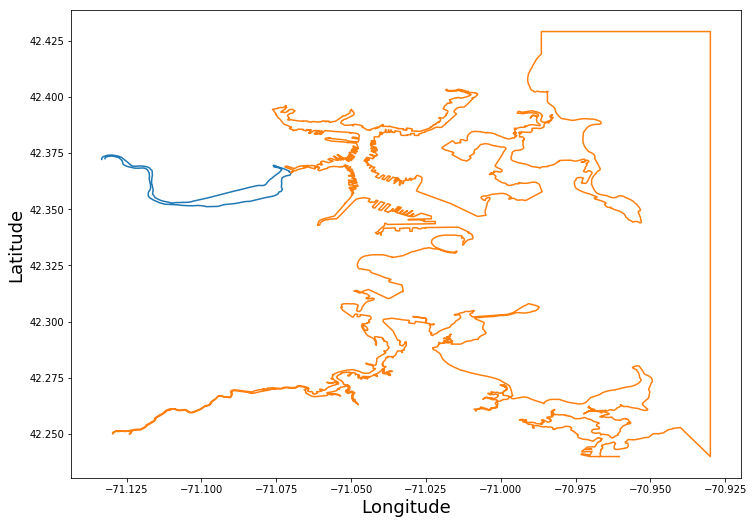

In [105]:
plt.figure(figsize = (12, 8.6))

index = 4
coast_comb = (
    [(coast_boxed[28][0][0], coast_boxed[28][0][1] + 0.01)] + 
    coast_boxed[28] +
    [(coast_boxed[28][-1][0] + 0.01, coast_boxed[28][-1][1])] +
    [(42.419 + 0.01, -70.94 + 0.01)] +
    [(coast_boxed[23][-1][0], -70.94 + 0.01)] +
    coast_boxed[23] 
             )

plt.plot([point[1] for point in hydro_boxed[index]], [point[0] for point in hydro_boxed[index]])

plt.plot([point[1] for point in coast_comb], [point[0] for point in coast_comb])
plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

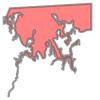

In [101]:
cr = geometry.LinearRing(coast_comb)
cs = geometry.Polygon(cr)
cs

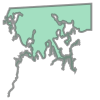

In [107]:
cs2 = cs.buffer(0)
cs2.is_valid
cs2

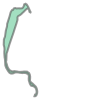

In [108]:
rr = geometry.LinearRing(hydro_boxed[4])
rs = geometry.Polygon(rr)
rs

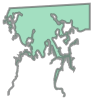

In [111]:
merged = cs2.union(rs)
merged

In [114]:
with open('/Users/Ben/Dropbox/Insight/coast/coast-crop.pkl', 'wb') as f:
    pickle.dump(coast_comb, f)

In [33]:
grid = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/merge-aws/coord-in/grid.csv')
len(grid)

34813

Text(0, 0.5, 'Latitude')

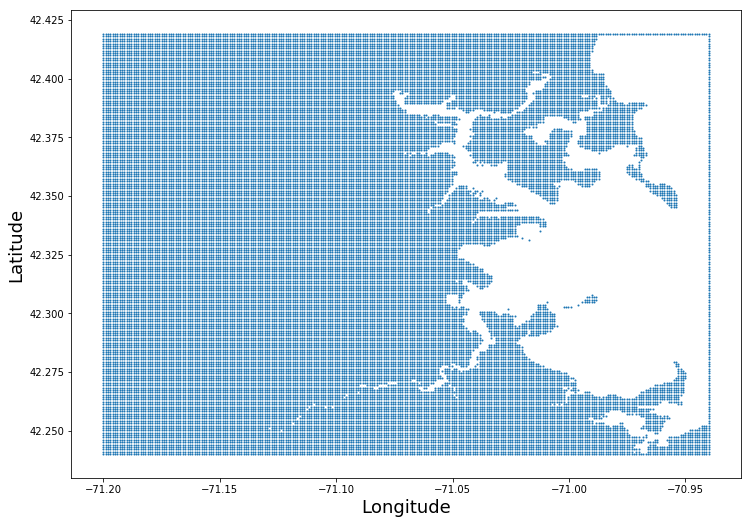

In [35]:
plt.figure(figsize = (12., 12))
plt.scatter(grid.lng, grid.lat, s = 1)
plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

In [112]:
keep = list()
for index, lat, lng in zip(range(len(grid)),grid.lat, grid.lng):
    point_obj = geometry.Point(lat, lng)
    keep.append(not merged.contains(point_obj))

grid_crop = grid[keep]
len(grid_crop)

34382

Text(0, 0.5, 'Latitude')

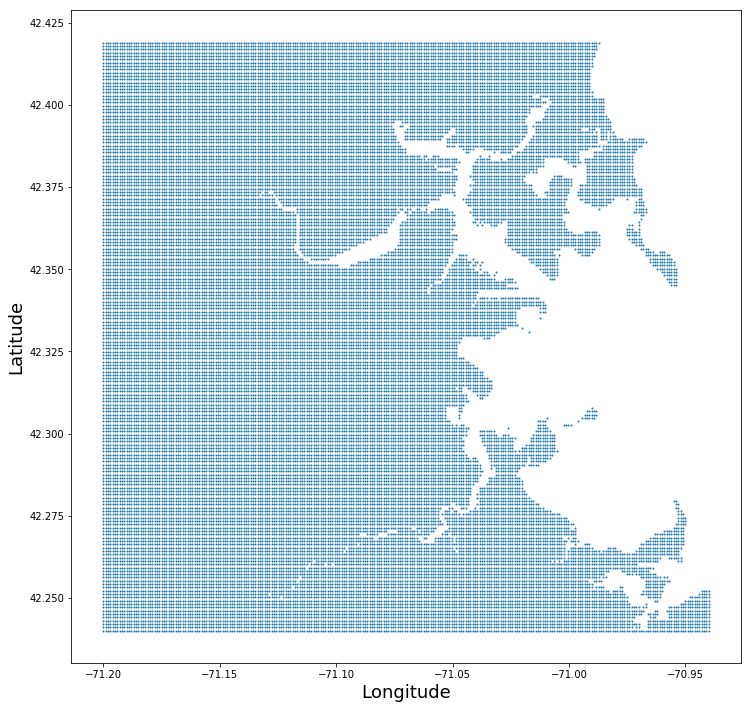

In [113]:
plt.figure(figsize = (12., 12))
plt.scatter(grid_crop.lng, grid_crop.lat, s = 1)
plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

In [ ]:
plt.figure(figsize = (12., 8.6))
index = 7
plt.plot([point[1] for point in coast_boxed[index]], [point[0] for point in coast_boxed[index]])
plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

In [116]:
# in make_grid.py I make a grid of points across the map and compute feature distances for each point
pred_grid1 = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/merge-aws/aws-results/out/grid-merge1.csv')
pred_grid2 = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/merge-aws/aws-results/out/grid-merge2.csv')
pred_grid3 = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/merge-aws/aws-results/out/grid-merge3.csv')
pred_grid4 = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/merge-aws/aws-results/out/grid-merge4.csv')

pred_grid = pd.concat([pred_grid1, pred_grid2, pred_grid3, pred_grid4])
pred_grid = pred_grid.drop('Unnamed: 0', axis = 1)

keep = list()
for lat, lng in zip(pred_grid.lat, pred_grid.lng):
    point_obj = geometry.Point(lat, lng)
    keep.append(not merged.contains(point_obj))

pred_grid_crop = pred_grid[keep]
pred_grid_crop.to_csv('/Users/Ben/Dropbox/Insight/data-merge/pred_grid_crop.csv')